<a href="https://colab.research.google.com/github/jambao24/-100Viz/blob/master/refined_document_BioNumPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install bionumpy
! pip install logomaker
! pip install git+https://github.com/bionumpy/npstructures.git@dev
import numpy as np
import bionumpy as bnp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import logomaker

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Biological sequence data analysis made efficient using BioNumPy

In this post, I intend to show how BioNumPy enables fast and efficient analysis of non-numeric biological sequence data. Here, my need is to analyse collections of short amino acid sequences (15-18 amino acid residues in length) of individuals with two different classes (e.g. disease vs. healthy) and build a predictive model to predict the class label using sequence data.

## Data loading and encoding sequence data

BioNumPy has many built-in functions to parse a wide range of common file formats in Bioinformatics (e.g. FASTA, FASTQ, SAM, BAM, BED, GFF, VCF, etc.). However, in this case, I have a collection of amino acid sequences in a tab-separated file format. I will load the data using the standard pandas functionality and encode the amino acid sequences into ragged numpy arrays using BioNumPy.

In [ ]:
# download data for demonstration
! wget https://zenodo.org/records/10952760/files/immune_repertoires.zip && unzip immune_repertoires.zip && rm immune_repertoire.zip

In [ ]:
data_path = '/content/immune_repertoires'
metadata = pd.read_csv(data_path + '/metadata.csv', index_col=0)
repertoires = [pd.read_csv(data_path + '/' + filename, header=None, sep="\t", usecols=[1]).iloc[:,0].to_list() for filename in metadata['filename']]
y=np.array(metadata['label_positive'])# the target variable for prediction
print(np.unique(y[0:100]), np.unique(y[101:200])) # for the ease of demonstration, the first 100 files belong to the positive class and the next 100 files belong to the negative class

[ True] [False]


In [ ]:
encoded_repertoires = [bnp.as_encoded_array(repertoire, bnp.encodings.alphabet_encoding.AminoAcidEncoding) for repertoire in repertoires] # encoding the amino acid sequences into ragged numpy arrays
aa_alphabet = bnp.encodings.alphabet_encoding.AminoAcidEncoding.get_labels() # the amino acid alphabet used for encoding

## Exploratory data analysis

So, what does the encoded repertoires look like? The shape of the first encoded repertoire shows that it is a ragged array with 121246 amino acid sequences of non-uniform lengths.

In [ ]:
encoded_repertoires[0].shape

(121246, array([20, 13,  9, ..., 14, 16, 16]))

Okay, since the sequences are of non-uniform lengths, a natural curiosity is to see the distribution of sequence lengths, summarize them, and maybe even compare the distributions between the two classes.

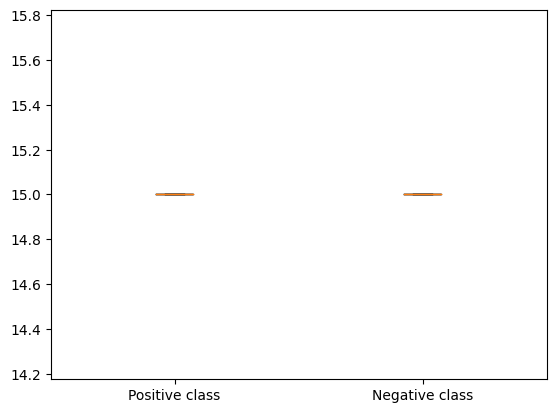

In [ ]:
repertoire_seq_lens = [repertoire.shape[1] for repertoire in encoded_repertoires] # since the second element of the shape holds the sequence lengths
mean_seq_lens = [round(np.mean(seq_lens)) for seq_lens in repertoire_seq_lens] # calculating the mean sequence lengths for each repertoire
plt.boxplot([mean_seq_lens[0:100], mean_seq_lens[101:200]], labels=['Positive class', 'Negative class']) # since we know the first 100 files belong to the positive class and the next 100 files belong to the negative class
plt.show()

There was no difference in the mean sequence lengths between the two classes. However, the distribution of sequence lengths could be different between the two classes. Let's visualize the distributions of sequence lengths for the two classes. To make sure that my visualization choice is not hiding something, let me add a control feature to the plot. I will add a random repertoire with sequence lengths varying from 12 to 20 with equal proportions and see if that will stand out.

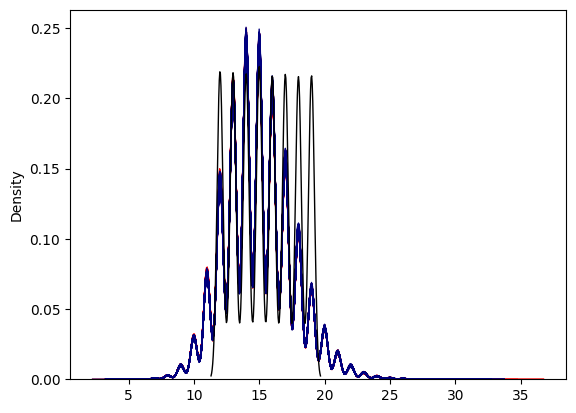

In [ ]:
random_repertoire_seq_lens = np.random.randint(12, 20, 100000)
for i, data in enumerate(repertoire_seq_lens):
    label = 'red' if i < 100 else 'navy'
    sns.kdeplot(data, color=label, linewidth=1)
sns.kdeplot(random_repertoire_seq_lens, color='black', linewidth=1)
plt.show()

Aha! This tells that the distribution of sequence lengths looks quite similar between the two classes. However, the distribution of sequence lengths in the random repertoire is quite different from the two classes. That was a good sanity check.

### Does the positional amino acid composition differ between the two classes?

To get a clue on this question in a simplistic way, I can access the bionumpy-encoded sequence arrays with unequal lengths and access each column. For instance, if I want to access the first column (first position of all sequences) in the first repertoire, I would do:

In [ ]:
bnp.count_encoded(encoded_repertoires[0].get_column_values(0))

EncodedCounts(alphabet=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '*'], counts=array([     0, 121246,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0]), row_names=None)

This shows that in this collection of sequences, the second element of the alphabet ('C') is present 121246 times in the first position of the sequences. It is possible to extract separately the labels, counts or proportions from the EncodedCounts object. For instance, to get the proportions of amino acids at the first position of the first repertoire, I can do:

In [ ]:
bnp.count_encoded(encoded_repertoires[0].get_column_values(0)).proportions

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

I will concatenate all the sequences of positive classes and negative classes separately and compute the positional amino acid proportions. I will then visualize the positional amino acid counts for the two classes. For this, I will wrap the functionality of `bnp.count_encoded(encoded_repertoires[i].get_column_values(i))` into a function that will return the positional amino acid counts/proportions for a given repertoire.

In [ ]:
pos_repertoires = np.concatenate((encoded_repertoires[0:100]), axis=0)
neg_repertoires = np.concatenate((encoded_repertoires[101:200]), axis=0)
print(pos_repertoires.shape, neg_repertoires.shape)

(11960196, array([20, 13,  9, ..., 14, 16, 16])) (11841702, array([12, 13, 13, ..., 13, 14, 13]))


In [ ]:
def get_positional_counts(repertoire):
    positional_counts = []
    for i in range(np.max(repertoire.shape[1])): # iterate over the columns of the ragged array
        positional_counts.append(bnp.count_encoded(repertoire.get_column_values(i)).proportions) # note that I am accessing the proportions directly here. I could also access the counts instead.
    return np.vstack(positional_counts).T

pos_pfm = get_positional_counts(pos_repertoires)
neg_pfm = get_positional_counts(neg_repertoires)
pos_pfm.shape, neg_pfm.shape

((21, 36), (21, 33))

Since I have the positional weights, I can visualize them using a sequence logo plot. I will use the logomaker library for this purpose.

(-1.0, 36.0)

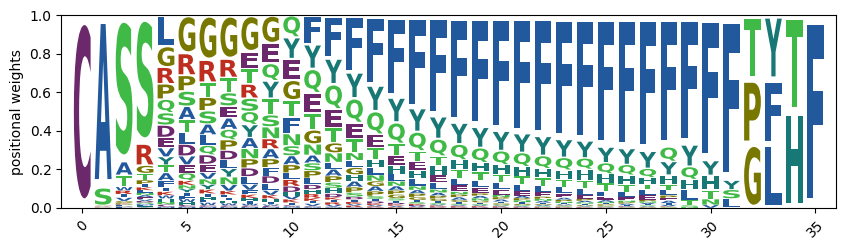

In [ ]:
pos_pwm = pd.DataFrame(pos_pfm.T, columns=aa_alphabet)
logo = logomaker.Logo(pos_pwm,
                      color_scheme='NajafabadiEtAl2017',
                         vpad=.1,
                         width=.8)

logo.style_xticks(anchor=0, spacing=5, rotation=45)
logo.ax.set_ylabel('positional weights')
logo.ax.set_xlim([-1, len(pos_pwm)])

The above visualization fits well with the known biology of the sequences. Those who are are familiar with the CDR3 beta amino acid sequences of T cell receptors will recognize the conserved 'CASS' at the beginning of the sequences.

Now, I am curious whether the positive and negative class positional amino acid compositions differ. I will compute the difference between the positional frequency matrices (PFMs) of the two classes and visualize the difference. First, I will pad the negative class PFM with zeros to make it the same shape as the positive class PFM.

In [ ]:
diff_cols = pos_pfm.shape[1] - neg_pfm.shape[1]
neg_pfm = np.pad(neg_pfm, ((0, 0), (0, diff_cols)), 'constant', constant_values=(0, 0))
diff_pfm = pos_pfm - neg_pfm
diff_pfm = pd.DataFrame(diff_pfm, index=aa_alphabet).T

In [ ]:
fig = px.imshow(diff_pfm.T)
fig.show()

The above visualization shows that the positive and negative classes differ in the end portions of the sequences, and it also shows which residues are more prevalent in the positive class compared to the negative class and vice versa in those positions.

## Machine learning on k-mer frequencies of positive and negative class sequence collections

Often, the k-mer representation of biological sequences is used as input features for machine learning models. I will count k-mer frequencies using BioNumPy and use the k-mer representation of the sequences to build a predictive model to predict the class label.

In [ ]:
repertoire_kmer_counts = [bnp.sequence.count_kmers(encoded_repertoire, 3) for encoded_repertoire in encoded_repertoires]
feature_names = repertoire_kmer_counts[0].labels

Let us take a look at the first k-mer count object. The EncodedCounts object has the counts, proportions, and labels of the k-mers. One could also query the most common k-mers in the collection. For instance:

In [ ]:
repertoire_kmer_counts[0].most_common(10) # the most common 10 k-mers in the first repertoire

EncodedCounts(alphabet=['CAS', 'ASS', 'QYF', 'EQY', 'YEQ', 'TQY', 'SSL', 'AFF', 'QFF', 'EQF'], counts=array([92364, 72794, 46259, 25755, 19569, 17342, 16546, 13853, 13362,
       13068]), row_names=None)

Since I want the relative frequencies of the k-mers in each example, I will stack the proportions of the k-mers in each repertoire and use them as features for the machine learning model. One can use numpy's `vstack` function to stack the proportions of the k-mers in each repertoire.

In [ ]:
X = np.vstack([repertoire_kmer_counts[i].proportions for i in range(len(repertoire_kmer_counts))])

Alternatively one can also use the `vstack` method of the EncodedCounts object to stack the proportions of the k-mers in the first repertoire with a list of EncodedCounts objects. For instance:

In [ ]:
x_temp = repertoire_kmer_counts[0].vstack(repertoire_kmer_counts)

Now, I have the feature matrix `X` and the target variable `y` (from the first chunk of data loading). One can imagine the possibilities from here. As a very simplistic demonstration, I show what can be a cross-validation score with a logistic regression model to predict the class label using the k-mer frequencies.

In [ ]:
log_reg = LogisticRegression(solver='liblinear')
scores = cross_val_score(log_reg, X, y, cv=5, scoring='roc_auc')
true_score = scores.mean()
print("AUC for each fold:", scores)
print("Mean ROC AUC: {:.2f}".format(scores.mean()))
print("Standard deviation: {:.2f}".format(scores.std()))

AUC for each fold: [0.8125 0.8225 0.735  0.7275 0.7575]
Mean ROC AUC: 0.77
Standard deviation: 0.04


To see which k-mers are most important in the model, I can access the coefficients of the logistic regression model and sort them to see the top k-mers that contribute to the prediction.

In [ ]:
log_reg.fit(X, y)
coefs = np.abs(log_reg.coef_[0])
top_indices = np.argsort(coefs)[-20:]
for i in top_indices:
    print(f"Feature {feature_names[i]} - Coefficient: {coefs[i]}")

Feature QHF - Coefficient: 0.0006739057476385675
Feature QFF - Coefficient: 0.0006792249806370557
Feature LFF - Coefficient: 0.0007228346261297705
Feature GYE - Coefficient: 0.0007318460194680742
Feature DEQ - Coefficient: 0.0007358627084350643
Feature NQP - Coefficient: 0.0007412978764512192
Feature SSE - Coefficient: 0.0007491351165623449
Feature PQH - Coefficient: 0.000750472262715595
Feature QPQ - Coefficient: 0.0007506023640487915
Feature SAR - Coefficient: 0.0009703863348800657
Feature SSG - Coefficient: 0.0010402277224535884
Feature GYT - Coefficient: 0.0010837158457156298
Feature YGY - Coefficient: 0.0010844086377673153
Feature YTF - Coefficient: 0.0011378468143637722
Feature CSA - Coefficient: 0.0011554850487961444
Feature YEQ - Coefficient: 0.0025756154718026975
Feature QYF - Coefficient: 0.0027122221101917635
Feature CAS - Coefficient: 0.0027362649485541735
Feature ASS - Coefficient: 0.0027399683459214436
Feature EQY - Coefficient: 0.002900089895887727
